In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [16]:
class Generator(nn.Module):
    def __init__(self, channels):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 7, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, channels,4,2,1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(128, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

class Discriminator(nn.Module):
    def __init__(self, channels, size):
        super(Discriminator, self).__init__()
        self.img_size = size
        self.dis = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512 *(self.img_size//16)*(self.img_size//16), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dis(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [3]:
def get_dataset(dataset_name):
    if dataset_name == 'MNIST':
        img_channels = 1
        img_size = 28
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
    elif dataset_name == 'CIFAR10':
        img_channels = 3
        img_size = 32
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        dataset = datasets.CIFAR10(root='cifar10_data', train=True, transform=transform, download=True)
    elif dataset_name == 'CIFAR100':
        img_channels = 3
        img_size = 32
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        dataset = datasets.CIFAR100(root='cifar100_data', train=True, transform=transform, download=True)

    return dataset, img_channels, img_size

In [13]:
def train(dataset_name,g_lr=1e-4, d_lr=5e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset, img_channels, img_size = get_dataset(dataset_name)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    generator = Generator(img_channels).to(device)
    discriminator = Discriminator(img_channels, img_size).to(device)

    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=g_lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))
    num_epochs = 60
    fixed_noise = torch.randn(64, 100, 1, 1).to(device)

    g_losses = []
    d_losses = []

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

#             # Smooth labels
#             real_labels = torch.full((batch_size,), 0.9, dtype=torch.float, device=device)
#             fake_labels = torch.full((batch_size,), 0.1, dtype=torch.float, device=device)
            real_labels = torch.ones((batch_size,),device=device)
            fake_labels = torch.zeros((batch_size,),device=device)

            # Train Discriminator
            optimizer_d.zero_grad()
            outputs = discriminator(real_images).view(-1)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(batch_size, 100, 1, 1).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach()).view(-1)
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()

            optimizer_d.step()

            d_loss = d_loss_real + d_loss_fake
            d_losses.append(d_loss.item())

            # Train Generator
            optimizer_g.zero_grad()
            outputs = discriminator(fake_images).view(-1)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()

            optimizer_g.step()

            g_losses.append(g_loss.item())

            if i % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                fake_images = generator(fixed_noise).cpu()
                grid = utils.make_grid(fake_images, padding=2, normalize=True)
                plt.figure(figsize=(8, 8))
                plt.axis("off")
                plt.title("Generated Images")
                if grid.shape[0] == 1:
                    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")  # Handle grayscale images
                else:
                    plt.imshow(np.transpose(grid, (1, 2, 0)))  # Handle RGB images
                plt.show()

    # Plot the loss curves
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(g_losses, label="G")
    plt.plot(d_losses, label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch [1/60], Step [1/938], d_loss: 1.4207757711410522, g_loss: 0.73280930519104
Epoch [1/60], Step [101/938], d_loss: 1.1942427158355713, g_loss: 0.8386794328689575
Epoch [1/60], Step [201/938], d_loss: 1.0229079723358154, g_loss: 1.0091341733932495
Epoch [1/60], Step [301/938], d_loss: 0.9169760942459106, g_loss: 1.1859328746795654
Epoch [1/60], Step [401/938], d_loss: 0.8607162833213806, g_loss: 1.3107378482818604
Epoch [1/60], Step [501/938], d_loss: 0.7124738693237305, g_loss: 1.4774353504180908
Epoch [1/60], Step [601/938], d_loss: 0.48025527596473694, g_loss: 1.6147220134735107
Epoch [1/60], Step [701/938], d_loss: 0.5778301954269409, g_loss: 1.7107436656951904
Epoch [1/60], Step [801/938], d_loss: 0.3749443590641022, g_loss: 1.8513723611831665
Epoch [1/60], Step [901/938], d_loss: 0.4331353008747101, g_loss: 1.9776818752288818
Epoch [2/60], Step [1/938], d_loss: 0.308185875415802, g_loss: 1.9265727996826172
Epoch [2/60], Step [101/938], d_loss: 0.2719570994377136, g_loss: 2.116

Epoch [10/60], Step [701/938], d_loss: 0.1237979456782341, g_loss: 3.3224356174468994
Epoch [10/60], Step [801/938], d_loss: 0.20551979541778564, g_loss: 2.497840642929077
Epoch [10/60], Step [901/938], d_loss: 0.12295699119567871, g_loss: 3.5064949989318848


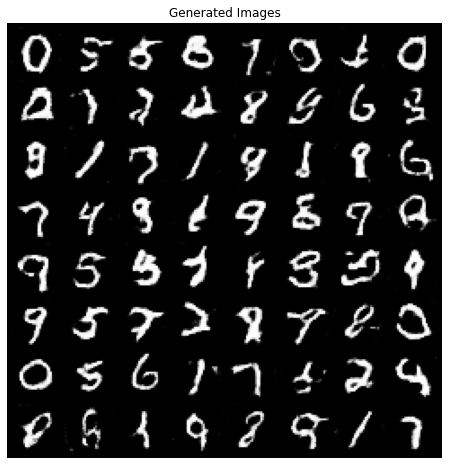

Epoch [11/60], Step [1/938], d_loss: 0.28469789028167725, g_loss: 3.2371695041656494
Epoch [11/60], Step [101/938], d_loss: 0.08983366191387177, g_loss: 3.540465831756592
Epoch [11/60], Step [201/938], d_loss: 0.11710367351770401, g_loss: 4.015411853790283
Epoch [11/60], Step [301/938], d_loss: 0.08123546838760376, g_loss: 3.694434642791748
Epoch [11/60], Step [401/938], d_loss: 0.08194370567798615, g_loss: 3.4491686820983887
Epoch [11/60], Step [501/938], d_loss: 0.16922308504581451, g_loss: 3.612926483154297
Epoch [11/60], Step [601/938], d_loss: 0.10970527678728104, g_loss: 3.9070358276367188
Epoch [11/60], Step [701/938], d_loss: 0.09741286188364029, g_loss: 3.8200390338897705
Epoch [11/60], Step [801/938], d_loss: 0.12651154398918152, g_loss: 3.532626152038574
Epoch [11/60], Step [901/938], d_loss: 0.47775375843048096, g_loss: 2.3564486503601074
Epoch [12/60], Step [1/938], d_loss: 0.19604861736297607, g_loss: 3.935455799102783
Epoch [12/60], Step [101/938], d_loss: 0.097016811370

Epoch [20/60], Step [601/938], d_loss: 0.05428183078765869, g_loss: 5.0739593505859375
Epoch [20/60], Step [701/938], d_loss: 0.08582976460456848, g_loss: 4.3977460861206055
Epoch [20/60], Step [801/938], d_loss: 0.02845003828406334, g_loss: 4.530838966369629
Epoch [20/60], Step [901/938], d_loss: 0.06591325253248215, g_loss: 4.0923309326171875


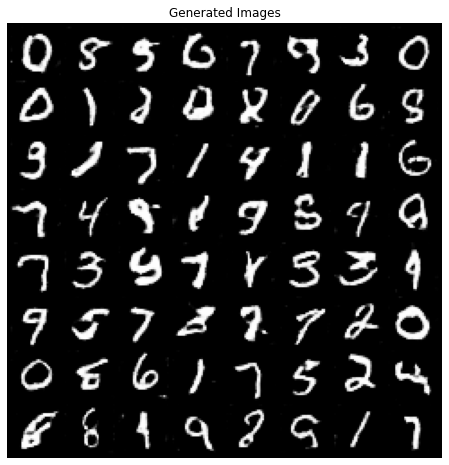

Epoch [21/60], Step [1/938], d_loss: 0.3556751608848572, g_loss: 5.71103048324585
Epoch [21/60], Step [101/938], d_loss: 0.025275252759456635, g_loss: 5.956897258758545
Epoch [21/60], Step [201/938], d_loss: 0.514772355556488, g_loss: 3.5901830196380615
Epoch [21/60], Step [301/938], d_loss: 0.019124038517475128, g_loss: 4.211976051330566
Epoch [21/60], Step [401/938], d_loss: 0.03467151150107384, g_loss: 4.8659772872924805
Epoch [21/60], Step [501/938], d_loss: 0.028418757021427155, g_loss: 4.995070457458496
Epoch [21/60], Step [601/938], d_loss: 0.04117007181048393, g_loss: 4.5810017585754395
Epoch [21/60], Step [701/938], d_loss: 0.053683795034885406, g_loss: 4.63196325302124
Epoch [21/60], Step [801/938], d_loss: 0.7235963940620422, g_loss: 3.6261231899261475
Epoch [21/60], Step [901/938], d_loss: 0.1486322581768036, g_loss: 4.06831169128418
Epoch [22/60], Step [1/938], d_loss: 0.05334267020225525, g_loss: 4.416258811950684
Epoch [22/60], Step [101/938], d_loss: 0.07621098309755325

Epoch [30/60], Step [601/938], d_loss: 0.055745240300893784, g_loss: 3.817748785018921
Epoch [30/60], Step [701/938], d_loss: 0.03088958002626896, g_loss: 4.6498308181762695
Epoch [30/60], Step [801/938], d_loss: 0.03703487291932106, g_loss: 5.184352874755859
Epoch [30/60], Step [901/938], d_loss: 0.021417204290628433, g_loss: 5.061540126800537


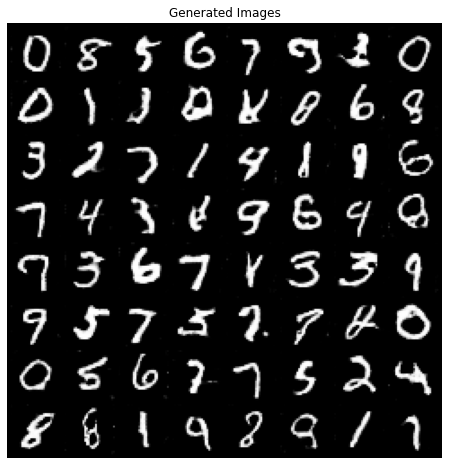

Epoch [31/60], Step [1/938], d_loss: 0.04997767508029938, g_loss: 4.67891788482666
Epoch [31/60], Step [101/938], d_loss: 0.07538644969463348, g_loss: 4.575432777404785
Epoch [31/60], Step [201/938], d_loss: 0.03703323379158974, g_loss: 4.614646911621094
Epoch [31/60], Step [301/938], d_loss: 0.02950572595000267, g_loss: 5.655081748962402
Epoch [31/60], Step [401/938], d_loss: 0.20837461948394775, g_loss: 5.152951240539551
Epoch [31/60], Step [501/938], d_loss: 0.022428331896662712, g_loss: 5.643059253692627
Epoch [31/60], Step [601/938], d_loss: 0.43613308668136597, g_loss: 3.4167070388793945
Epoch [31/60], Step [701/938], d_loss: 0.5187026262283325, g_loss: 3.3471765518188477
Epoch [31/60], Step [801/938], d_loss: 0.04719110205769539, g_loss: 4.742748260498047
Epoch [31/60], Step [901/938], d_loss: 0.017290718853473663, g_loss: 5.827250957489014
Epoch [32/60], Step [1/938], d_loss: 0.08077111840248108, g_loss: 4.3280029296875
Epoch [32/60], Step [101/938], d_loss: 0.10439170151948929

Epoch [40/60], Step [601/938], d_loss: 0.06244543567299843, g_loss: 5.153220176696777
Epoch [40/60], Step [701/938], d_loss: 0.008838821202516556, g_loss: 6.230281829833984
Epoch [40/60], Step [801/938], d_loss: 0.007366903126239777, g_loss: 7.046204090118408
Epoch [40/60], Step [901/938], d_loss: 0.02259637415409088, g_loss: 5.841634750366211


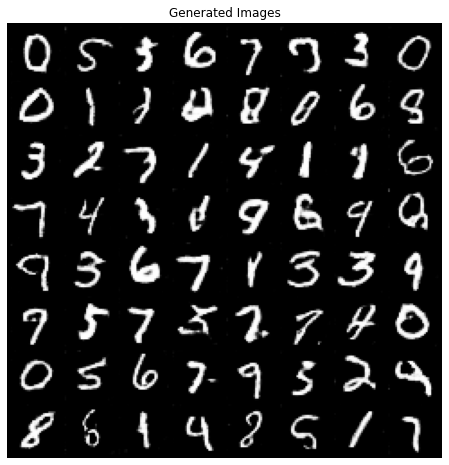

Epoch [41/60], Step [1/938], d_loss: 0.10235725343227386, g_loss: 4.17193603515625
Epoch [41/60], Step [101/938], d_loss: 0.035587675869464874, g_loss: 4.713472366333008
Epoch [41/60], Step [201/938], d_loss: 0.009940247982740402, g_loss: 6.648253440856934
Epoch [41/60], Step [301/938], d_loss: 0.07814525067806244, g_loss: 4.624370574951172
Epoch [41/60], Step [401/938], d_loss: 0.15292751789093018, g_loss: 6.204148769378662
Epoch [41/60], Step [501/938], d_loss: 0.02446112595498562, g_loss: 6.343955039978027
Epoch [41/60], Step [601/938], d_loss: 0.09900133311748505, g_loss: 6.746513366699219
Epoch [41/60], Step [701/938], d_loss: 0.17869964241981506, g_loss: 4.347222328186035
Epoch [41/60], Step [801/938], d_loss: 0.07119898498058319, g_loss: 4.165278434753418
Epoch [41/60], Step [901/938], d_loss: 0.018345097079873085, g_loss: 5.557971000671387
Epoch [42/60], Step [1/938], d_loss: 0.012003479525446892, g_loss: 5.0336151123046875
Epoch [42/60], Step [101/938], d_loss: 0.1047110855579

Epoch [50/60], Step [601/938], d_loss: 0.04516821354627609, g_loss: 5.6472344398498535
Epoch [50/60], Step [701/938], d_loss: 0.015283697284758091, g_loss: 6.217474937438965
Epoch [50/60], Step [801/938], d_loss: 0.01545174140483141, g_loss: 5.895027160644531
Epoch [50/60], Step [901/938], d_loss: 0.08032076805830002, g_loss: 5.157207489013672


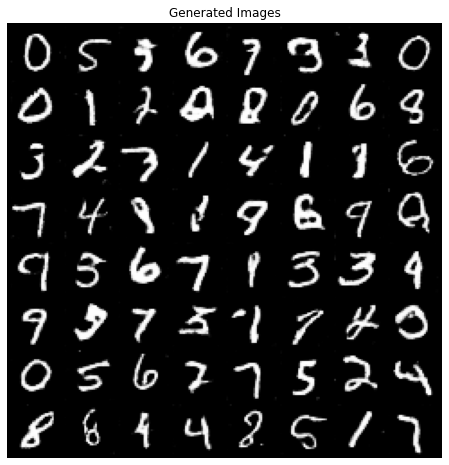

Epoch [51/60], Step [1/938], d_loss: 1.4047353267669678, g_loss: 5.583569526672363
Epoch [51/60], Step [101/938], d_loss: 0.05528273433446884, g_loss: 4.498237609863281
Epoch [51/60], Step [201/938], d_loss: 0.006882742512971163, g_loss: 7.465081214904785
Epoch [51/60], Step [301/938], d_loss: 0.08589457720518112, g_loss: 4.485620498657227
Epoch [51/60], Step [401/938], d_loss: 0.04816054925322533, g_loss: 4.876599311828613
Epoch [51/60], Step [501/938], d_loss: 0.012500138953328133, g_loss: 6.18419075012207
Epoch [51/60], Step [601/938], d_loss: 0.01701941341161728, g_loss: 4.259771347045898
Epoch [51/60], Step [701/938], d_loss: 0.020110804587602615, g_loss: 5.137187957763672
Epoch [51/60], Step [801/938], d_loss: 0.06083393096923828, g_loss: 5.118963241577148
Epoch [51/60], Step [901/938], d_loss: 0.09416905045509338, g_loss: 5.122450828552246
Epoch [52/60], Step [1/938], d_loss: 0.16404348611831665, g_loss: 5.9266180992126465
Epoch [52/60], Step [101/938], d_loss: 0.003988632466644

Epoch [60/60], Step [601/938], d_loss: 0.035181887447834015, g_loss: 6.592981338500977
Epoch [60/60], Step [701/938], d_loss: 0.022138148546218872, g_loss: 5.114713668823242
Epoch [60/60], Step [801/938], d_loss: 0.31867268681526184, g_loss: 7.185020446777344
Epoch [60/60], Step [901/938], d_loss: 0.0030827298760414124, g_loss: 7.425633430480957


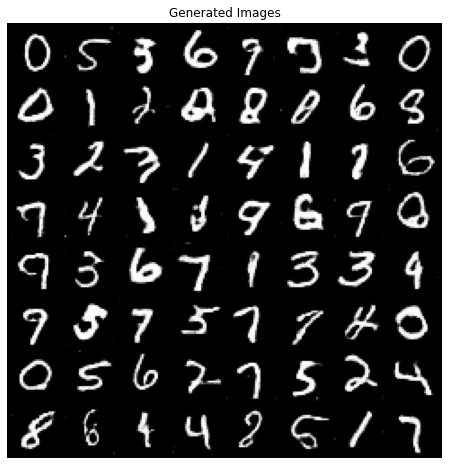

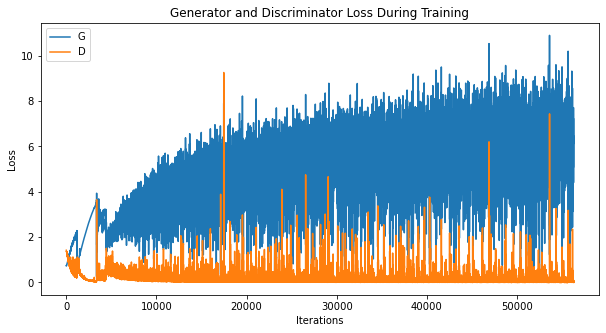

In [18]:
train('MNIST',1e-4,8e-5)

In [14]:
class Generator(nn.Module):
    def __init__(self, channels):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, channels, 4, 2, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

Files already downloaded and verified
Epoch [1/60], Step [1/782], d_loss: 1.434197187423706, g_loss: 1.4974908828735352
Epoch [1/60], Step [101/782], d_loss: 0.9613891839981079, g_loss: 3.1528401374816895
Epoch [1/60], Step [201/782], d_loss: 0.9209011793136597, g_loss: 2.0498855113983154
Epoch [1/60], Step [301/782], d_loss: 0.9325829744338989, g_loss: 1.7044214010238647
Epoch [1/60], Step [401/782], d_loss: 0.8962799310684204, g_loss: 2.07897686958313
Epoch [1/60], Step [501/782], d_loss: 0.7302431464195251, g_loss: 3.0631048679351807
Epoch [1/60], Step [601/782], d_loss: 0.8384321928024292, g_loss: 2.9626622200012207
Epoch [1/60], Step [701/782], d_loss: 0.7836250066757202, g_loss: 2.130490779876709
Epoch [2/60], Step [1/782], d_loss: 0.9936612844467163, g_loss: 1.7822781801223755
Epoch [2/60], Step [101/782], d_loss: 1.481933832168579, g_loss: 3.875140905380249
Epoch [2/60], Step [201/782], d_loss: 1.0797083377838135, g_loss: 1.2374814748764038
Epoch [2/60], Step [301/782], d_loss:

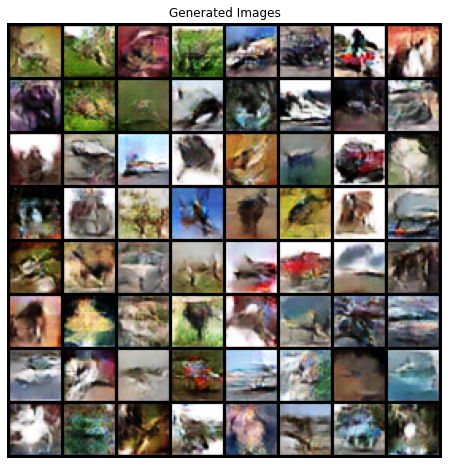

Epoch [11/60], Step [1/782], d_loss: 0.4499545693397522, g_loss: 1.4887495040893555
Epoch [11/60], Step [101/782], d_loss: 1.1503651142120361, g_loss: 4.951353549957275
Epoch [11/60], Step [201/782], d_loss: 1.119481086730957, g_loss: 0.6497636437416077
Epoch [11/60], Step [301/782], d_loss: 0.4595656096935272, g_loss: 3.6958184242248535
Epoch [11/60], Step [401/782], d_loss: 0.3591063916683197, g_loss: 2.584664821624756
Epoch [11/60], Step [501/782], d_loss: 1.2597368955612183, g_loss: 3.352996826171875
Epoch [11/60], Step [601/782], d_loss: 0.36305394768714905, g_loss: 4.047553539276123
Epoch [11/60], Step [701/782], d_loss: 1.687312126159668, g_loss: 1.1965844631195068
Epoch [12/60], Step [1/782], d_loss: 1.2502256631851196, g_loss: 4.822480201721191
Epoch [12/60], Step [101/782], d_loss: 2.2009594440460205, g_loss: 7.323513507843018
Epoch [12/60], Step [201/782], d_loss: 0.29435887932777405, g_loss: 3.0186173915863037
Epoch [12/60], Step [301/782], d_loss: 0.2007361352443695, g_los

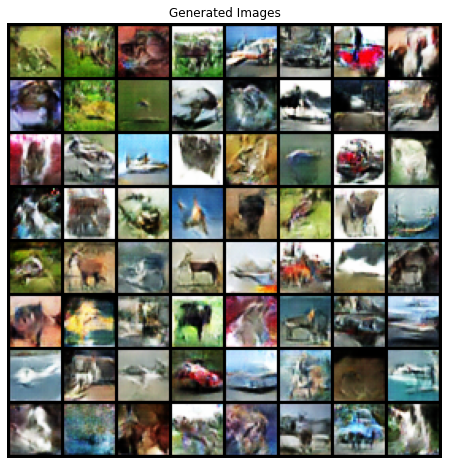

Epoch [21/60], Step [1/782], d_loss: 0.5394141674041748, g_loss: 1.7121062278747559
Epoch [21/60], Step [101/782], d_loss: 0.0950409546494484, g_loss: 3.932910919189453
Epoch [21/60], Step [201/782], d_loss: 0.33506104350090027, g_loss: 5.549071311950684
Epoch [21/60], Step [301/782], d_loss: 0.5515466928482056, g_loss: 1.0873286724090576
Epoch [21/60], Step [401/782], d_loss: 0.19950908422470093, g_loss: 3.9088428020477295
Epoch [21/60], Step [501/782], d_loss: 0.7187649011611938, g_loss: 1.3988667726516724
Epoch [21/60], Step [601/782], d_loss: 0.21789897978305817, g_loss: 3.89483380317688
Epoch [21/60], Step [701/782], d_loss: 0.15547841787338257, g_loss: 4.233831405639648
Epoch [22/60], Step [1/782], d_loss: 0.37589573860168457, g_loss: 2.320133686065674
Epoch [22/60], Step [101/782], d_loss: 0.22350531816482544, g_loss: 3.94256854057312
Epoch [22/60], Step [201/782], d_loss: 0.1977291703224182, g_loss: 3.910167694091797
Epoch [22/60], Step [301/782], d_loss: 0.8453643321990967, g_

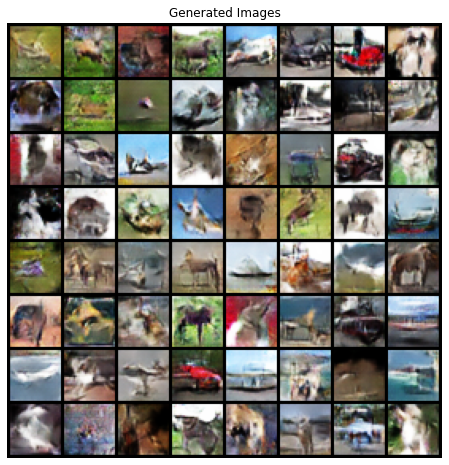

Epoch [31/60], Step [1/782], d_loss: 0.4845079779624939, g_loss: 5.680791854858398
Epoch [31/60], Step [101/782], d_loss: 0.3071761131286621, g_loss: 6.260324478149414
Epoch [31/60], Step [201/782], d_loss: 0.060642845928668976, g_loss: 3.9919936656951904
Epoch [31/60], Step [301/782], d_loss: 0.3309580981731415, g_loss: 6.396036148071289
Epoch [31/60], Step [401/782], d_loss: 0.08246715366840363, g_loss: 5.39044713973999
Epoch [31/60], Step [501/782], d_loss: 0.1229965090751648, g_loss: 6.165196895599365
Epoch [31/60], Step [601/782], d_loss: 1.3496917486190796, g_loss: 1.0404162406921387
Epoch [31/60], Step [701/782], d_loss: 0.2346504032611847, g_loss: 3.337947368621826
Epoch [32/60], Step [1/782], d_loss: 0.2660704255104065, g_loss: 3.5944314002990723
Epoch [32/60], Step [101/782], d_loss: 0.3540653586387634, g_loss: 2.8860511779785156
Epoch [32/60], Step [201/782], d_loss: 0.20530939102172852, g_loss: 3.655107021331787
Epoch [32/60], Step [301/782], d_loss: 0.18389511108398438, g_

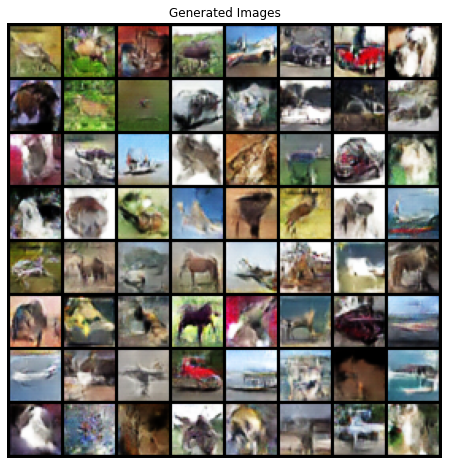

Epoch [41/60], Step [1/782], d_loss: 0.1642082780599594, g_loss: 4.160252094268799
Epoch [41/60], Step [101/782], d_loss: 0.10513050109148026, g_loss: 4.495563507080078
Epoch [41/60], Step [201/782], d_loss: 0.3113318681716919, g_loss: 4.539369583129883
Epoch [41/60], Step [301/782], d_loss: 0.20738428831100464, g_loss: 4.651372909545898
Epoch [41/60], Step [401/782], d_loss: 0.8363471031188965, g_loss: 1.1189262866973877
Epoch [41/60], Step [501/782], d_loss: 0.13673393428325653, g_loss: 4.071507453918457
Epoch [41/60], Step [601/782], d_loss: 0.36716899275779724, g_loss: 3.2966225147247314
Epoch [41/60], Step [701/782], d_loss: 0.06461940705776215, g_loss: 3.6519041061401367
Epoch [42/60], Step [1/782], d_loss: 0.2510836124420166, g_loss: 3.6813135147094727
Epoch [42/60], Step [101/782], d_loss: 0.09070353955030441, g_loss: 4.240079879760742
Epoch [42/60], Step [201/782], d_loss: 0.03757061809301376, g_loss: 4.742134094238281
Epoch [42/60], Step [301/782], d_loss: 0.22816818952560425

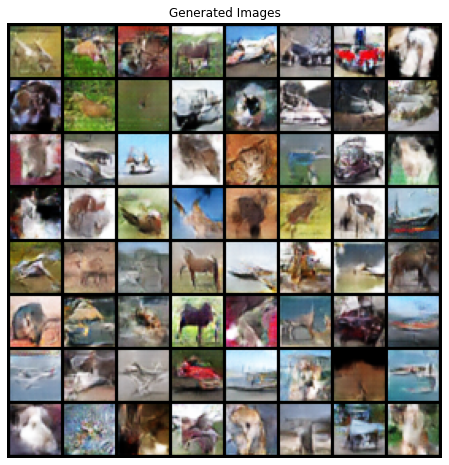

Epoch [51/60], Step [1/782], d_loss: 0.04525333270430565, g_loss: 4.282824993133545
Epoch [51/60], Step [101/782], d_loss: 0.18104104697704315, g_loss: 3.3664779663085938
Epoch [51/60], Step [201/782], d_loss: 0.052853770554065704, g_loss: 5.575621128082275
Epoch [51/60], Step [301/782], d_loss: 0.11610099673271179, g_loss: 5.725354194641113
Epoch [51/60], Step [401/782], d_loss: 0.0382208377122879, g_loss: 5.1511335372924805
Epoch [51/60], Step [501/782], d_loss: 0.09480379521846771, g_loss: 4.910600662231445
Epoch [51/60], Step [601/782], d_loss: 0.10208916664123535, g_loss: 6.060004711151123
Epoch [51/60], Step [701/782], d_loss: 0.20441977679729462, g_loss: 6.295107841491699
Epoch [52/60], Step [1/782], d_loss: 0.4029580354690552, g_loss: 7.659459114074707
Epoch [52/60], Step [101/782], d_loss: 0.02533765323460102, g_loss: 5.368161201477051
Epoch [52/60], Step [201/782], d_loss: 0.09290766716003418, g_loss: 4.975688934326172
Epoch [52/60], Step [301/782], d_loss: 0.0297411642968654

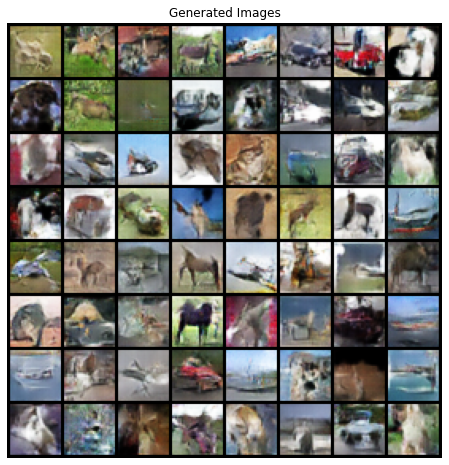

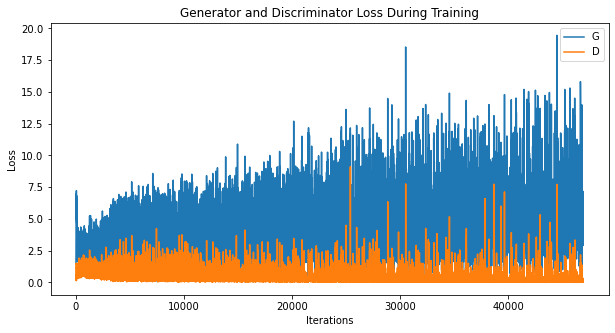

In [47]:
train('CIFAR10')

Files already downloaded and verified
Epoch [1/60], Step [1/782], d_loss: 1.4183270931243896, g_loss: 1.0412559509277344
Epoch [1/60], Step [101/782], d_loss: 0.16556067764759064, g_loss: 4.657155513763428
Epoch [1/60], Step [201/782], d_loss: 1.0870811939239502, g_loss: 2.3469913005828857
Epoch [1/60], Step [301/782], d_loss: 1.0923458337783813, g_loss: 3.070624351501465
Epoch [1/60], Step [401/782], d_loss: 0.7931523323059082, g_loss: 2.131221055984497
Epoch [1/60], Step [501/782], d_loss: 1.0113861560821533, g_loss: 1.466755747795105
Epoch [1/60], Step [601/782], d_loss: 0.5868198275566101, g_loss: 2.5045337677001953
Epoch [1/60], Step [701/782], d_loss: 0.8755269050598145, g_loss: 2.4960379600524902
Epoch [2/60], Step [1/782], d_loss: 0.6236568689346313, g_loss: 2.3481929302215576
Epoch [2/60], Step [101/782], d_loss: 0.6310390830039978, g_loss: 2.034179210662842
Epoch [2/60], Step [201/782], d_loss: 0.6831303834915161, g_loss: 1.9661297798156738
Epoch [2/60], Step [301/782], d_los

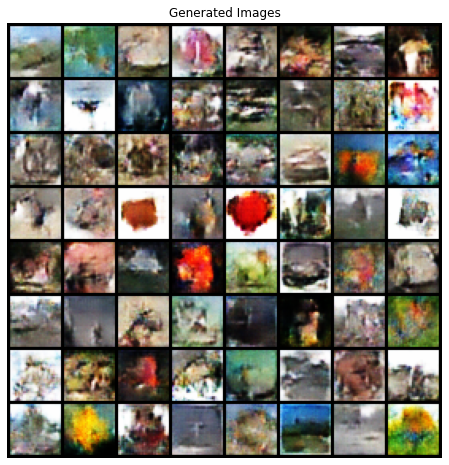

Epoch [11/60], Step [1/782], d_loss: 0.09727492183446884, g_loss: 3.7233409881591797
Epoch [11/60], Step [101/782], d_loss: 0.13265667855739594, g_loss: 3.2186784744262695
Epoch [11/60], Step [201/782], d_loss: 0.09585081040859222, g_loss: 4.517110347747803
Epoch [11/60], Step [301/782], d_loss: 0.23880116641521454, g_loss: 3.061793804168701
Epoch [11/60], Step [401/782], d_loss: 0.1746068149805069, g_loss: 4.24802303314209
Epoch [11/60], Step [501/782], d_loss: 0.19431883096694946, g_loss: 2.661264419555664
Epoch [11/60], Step [601/782], d_loss: 0.6350418925285339, g_loss: 2.226151943206787
Epoch [11/60], Step [701/782], d_loss: 0.29137375950813293, g_loss: 3.756779193878174
Epoch [12/60], Step [1/782], d_loss: 2.1759698390960693, g_loss: 6.457365036010742
Epoch [12/60], Step [101/782], d_loss: 0.30111485719680786, g_loss: 5.05196475982666
Epoch [12/60], Step [201/782], d_loss: 0.3802080452442169, g_loss: 3.0468664169311523
Epoch [12/60], Step [301/782], d_loss: 0.3294731378555298, g_

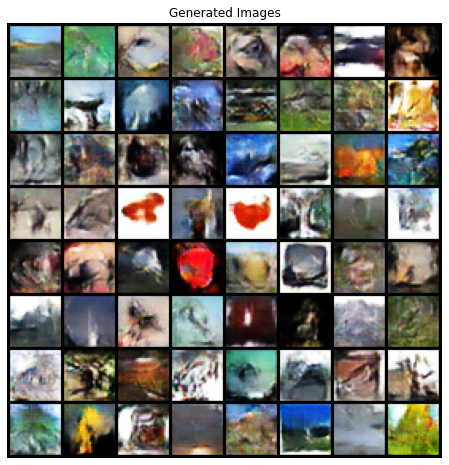

Epoch [21/60], Step [1/782], d_loss: 0.10740616917610168, g_loss: 3.4222233295440674
Epoch [21/60], Step [101/782], d_loss: 0.06433596462011337, g_loss: 4.40706729888916
Epoch [21/60], Step [201/782], d_loss: 0.2294304370880127, g_loss: 4.050526142120361
Epoch [21/60], Step [301/782], d_loss: 0.12795580923557281, g_loss: 3.7565340995788574
Epoch [21/60], Step [401/782], d_loss: 0.141689270734787, g_loss: 2.5712127685546875
Epoch [21/60], Step [501/782], d_loss: 0.049818724393844604, g_loss: 4.406550407409668
Epoch [21/60], Step [601/782], d_loss: 0.3311448097229004, g_loss: 4.4798583984375
Epoch [21/60], Step [701/782], d_loss: 0.264127254486084, g_loss: 2.1964941024780273
Epoch [22/60], Step [1/782], d_loss: 0.12000880390405655, g_loss: 3.3127200603485107
Epoch [22/60], Step [101/782], d_loss: 0.045195408165454865, g_loss: 4.723486423492432
Epoch [22/60], Step [201/782], d_loss: 0.09528538584709167, g_loss: 3.651702880859375
Epoch [22/60], Step [301/782], d_loss: 0.23230451345443726, 

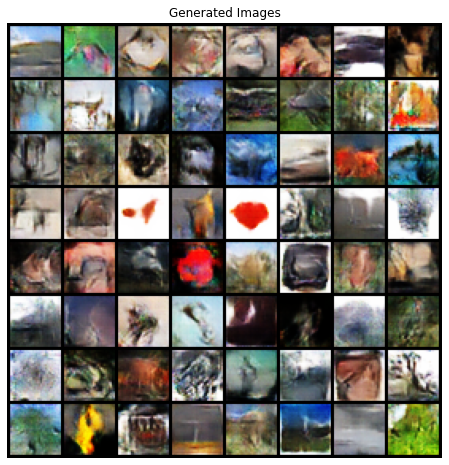

Epoch [31/60], Step [1/782], d_loss: 1.9875458478927612, g_loss: 8.294288635253906
Epoch [31/60], Step [101/782], d_loss: 0.044394414871931076, g_loss: 5.946056842803955
Epoch [31/60], Step [201/782], d_loss: 0.09336843341588974, g_loss: 3.765988826751709
Epoch [31/60], Step [301/782], d_loss: 0.4091642498970032, g_loss: 2.6192398071289062
Epoch [31/60], Step [401/782], d_loss: 0.06955130398273468, g_loss: 3.858222007751465
Epoch [31/60], Step [501/782], d_loss: 0.19827716052532196, g_loss: 3.4836983680725098
Epoch [31/60], Step [601/782], d_loss: 0.3748476803302765, g_loss: 5.646108150482178
Epoch [31/60], Step [701/782], d_loss: 0.02780252695083618, g_loss: 4.5709686279296875
Epoch [32/60], Step [1/782], d_loss: 0.024829823523759842, g_loss: 5.491329193115234
Epoch [32/60], Step [101/782], d_loss: 0.36155205965042114, g_loss: 5.251669883728027
Epoch [32/60], Step [201/782], d_loss: 0.04714839905500412, g_loss: 4.086063385009766
Epoch [32/60], Step [301/782], d_loss: 1.006818652153015

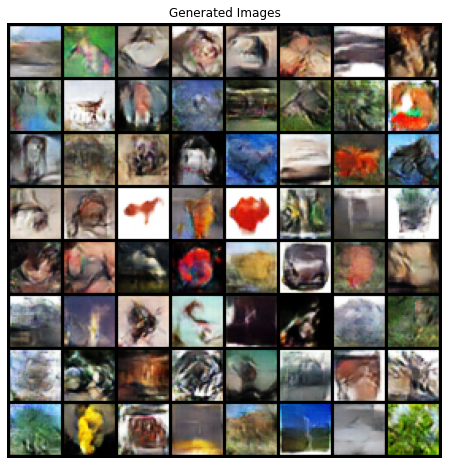

Epoch [41/60], Step [1/782], d_loss: 0.4640982449054718, g_loss: 6.258082866668701
Epoch [41/60], Step [101/782], d_loss: 0.5186896324157715, g_loss: 6.264806270599365
Epoch [41/60], Step [201/782], d_loss: 0.18311387300491333, g_loss: 3.3051767349243164
Epoch [41/60], Step [301/782], d_loss: 0.08794611692428589, g_loss: 7.055056095123291
Epoch [41/60], Step [401/782], d_loss: 1.483306646347046, g_loss: 7.148125171661377
Epoch [41/60], Step [501/782], d_loss: 0.2735059857368469, g_loss: 3.1875672340393066
Epoch [41/60], Step [601/782], d_loss: 0.0843234583735466, g_loss: 4.5683135986328125
Epoch [41/60], Step [701/782], d_loss: 0.15332777798175812, g_loss: 3.734833240509033
Epoch [42/60], Step [1/782], d_loss: 0.06494591385126114, g_loss: 5.045677185058594
Epoch [42/60], Step [101/782], d_loss: 0.0409950390458107, g_loss: 5.576371192932129
Epoch [42/60], Step [201/782], d_loss: 0.034061018377542496, g_loss: 4.2397661209106445
Epoch [42/60], Step [301/782], d_loss: 0.10835777223110199, 

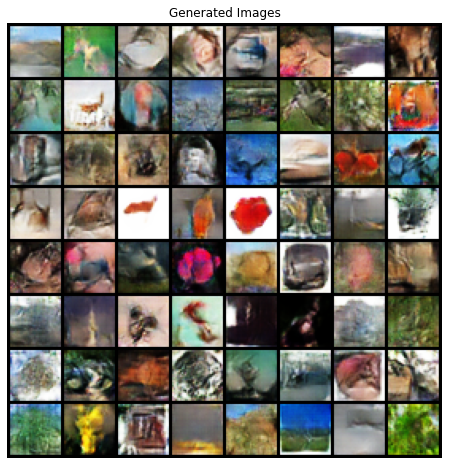

Epoch [51/60], Step [1/782], d_loss: 0.18097573518753052, g_loss: 4.174750804901123
Epoch [51/60], Step [101/782], d_loss: 0.01363535225391388, g_loss: 4.747772693634033
Epoch [51/60], Step [201/782], d_loss: 0.05213538557291031, g_loss: 7.0938825607299805
Epoch [51/60], Step [301/782], d_loss: 0.22157922387123108, g_loss: 2.8235180377960205
Epoch [51/60], Step [401/782], d_loss: 0.10512260347604752, g_loss: 3.666234254837036
Epoch [51/60], Step [501/782], d_loss: 0.024323157966136932, g_loss: 4.744598388671875
Epoch [51/60], Step [601/782], d_loss: 0.6442233920097351, g_loss: 0.486800879240036
Epoch [51/60], Step [701/782], d_loss: 0.04848383739590645, g_loss: 6.498917102813721
Epoch [52/60], Step [1/782], d_loss: 0.04110472649335861, g_loss: 3.991257667541504
Epoch [52/60], Step [101/782], d_loss: 0.03651845455169678, g_loss: 4.633835315704346
Epoch [52/60], Step [201/782], d_loss: 0.10749583691358566, g_loss: 5.894604682922363
Epoch [52/60], Step [301/782], d_loss: 0.513814747333526

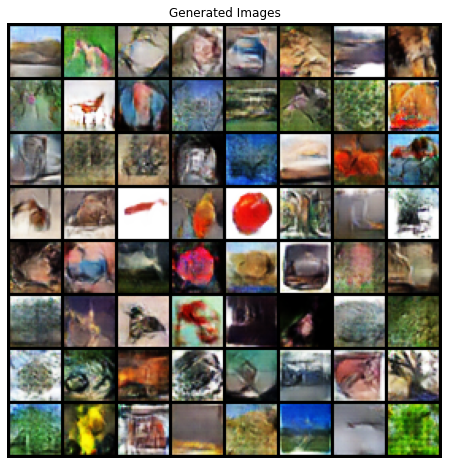

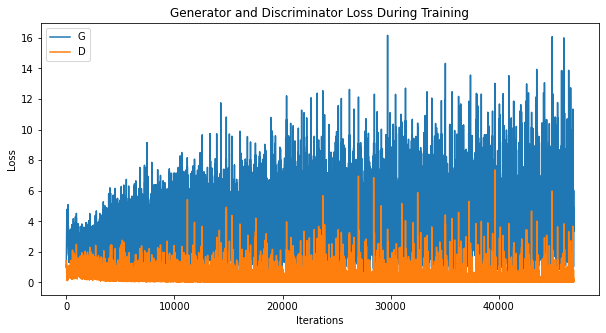

In [15]:
train('CIFAR100')